In [1]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd
from scipy.optimize import minimize, newton

# Importing some utils from local file. You'll need to make sure
# the file '' is in the same directory to make this import work.
# I've used * import here so that I didn't need to change the 
# names of the functions after moving them into a seperate file
from utils_quartic_solution import *

In [2]:
# Outer optimisation
def outer_optimise(inner_function, verbose=False):
    n0 = positions
    x0 = np.array([499, 999, 499])
    nlv_0 = prices.dot(positions) + cash

    def gross_delta_position(d_n_ij):
        return d_n_ij.sum()

    def nlv_beats_margin(d_n_ij, n0_ij, nlv):
        n_ij = n0_ij - np.sign(n0_ij) * d_n_ij

        margin = inner_function(n_ij, 0.15)

        if verbose:
            print(nlv + margin, nlv, margin, n_ij)

        return nlv + margin

    def position_reduction_above_zero(d_n_ij):
        """constrain all elements of x to be >= 0"""
        return d_n_ij

    def position_reduction_below_initial(d_n_ij, n0_ij):
        """constrain all elements of x to be <= |n0_ij|"""
        return np.abs(n0_ij) - d_n_ij

    constraints = [{'type': 'ineq', 'fun': nlv_beats_margin, 'args': (n0, nlv_0)},
                   {'type': 'ineq', 'fun': position_reduction_below_initial, 'args': (n0,)},
                   {'type': 'ineq', 'fun': position_reduction_above_zero}]

    results = minimize(gross_delta_position, x0, constraints=constraints)

    return results

In [3]:
# Setting up the World State
cash = -500
spot = 60

# Options are Call, Call and Call with K,n = 55, +500; 60, -1000; 65, +500
strikes = 55, 60, 65
r, q = 0.03, 0.01
tte = 0.25
vol = 0.15

args = [(strikes[0], tte, spot, vol, r, q, 1), 
        (strikes[1], tte, spot, vol, r, q, 1), 
        (strikes[2], tte, spot, vol, r, q, 1)]

positions = np.array([500, -1000, 500])
prices = np.array([spot_price(*args[0]), spot_price(*args[1]), spot_price(*args[2])])

In [4]:
def calculate_matrices(_positions):
    deltas = np.array([relative_delta(*args[0]), relative_delta(*args[1]), relative_delta(*args[2])])
    vegas = np.array([relative_vega(*args[0]), relative_vega(*args[1]), relative_vega(*args[2])])

    gammas = np.array([relative_gamma(*args[0]), relative_gamma(*args[1]), relative_gamma(*args[2])])
    vannas = np.array([relative_vanna(*args[0]), relative_vanna(*args[1]), relative_vanna(*args[2])])
    volgas = np.array([relative_volga(*args[0]), relative_volga(*args[1]), relative_volga(*args[2])])

    g = np.array([deltas.dot(_positions), vegas.dot(_positions)])
    B = np.matrix([[gammas.dot(_positions), vannas.dot(_positions)],
                   [vannas.dot(_positions), volgas.dot(_positions)]])

    return g, B

def val_func(x, g, B, c=0.15):
    return (x.dot(g) + 0.5 * x.transpose().dot(B).dot(x)[0,0])

def min_theta(theta, g, B, c=0.15):
    x = np.array([c*np.cos(theta), c*np.sin(theta)])
    return (x.dot(g) + 0.5 * x.transpose().dot(B).dot(x)[0,0])

def min_theta_grad(theta, g, B, c=0.15):
    x = np.array([c*np.cos(theta), c*np.sin(theta)])
    x_dash = np.array([-c*np.sin(theta), c*np.cos(theta)])
    return (x_dash.dot(g) + x.transpose().dot(B).dot(x_dash)[0,0])

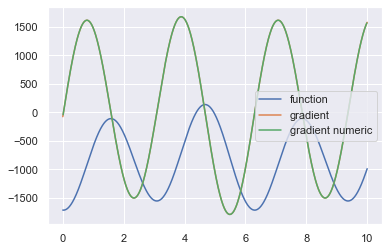

In [5]:
# Plot the value function by theta to get some intuition for the problem (and demonstrate the gradient function works!)
test_positions = np.array([500, -1000, 500])

g_vec, B_mat = calculate_matrices(test_positions)

angles = np.linspace(0, 10, 1000)

df = pd.DataFrame([angles, [min_theta(x, g_vec, B_mat) for x in angles], [min_theta_grad(x, g_vec, B_mat) for x in angles]], columns=angles).transpose()
df.columns = ['theta', 'func', 'grad']
df['numeric'] = (df['func'].shift(1) - df['func'].shift(-1)) / (df['theta'].shift(1) - df['theta'].shift(-1))

plt.plot(df['func'], label='function')
plt.plot(df['grad'], label='gradient')
plt.plot(df['numeric'], label='gradient numeric')

plt.legend()

In [6]:
# Find the worst quadratic direction, analytically in closed form

def find_worst_direction_analytic(g_vec, B_mat, c=0.15):

    # If positive semidefinite, and global solution inside circle, return this point
    eigenvalues, eigenvectors = np.linalg.eig(B_mat)
    if np.all(eigenvalues > 0.):
        maximiser = -np.linalg.inv(B_mat).dot(g_vec)
        distance = maximiser.dot(maximiser.transpose())[0, 0]

        if distance < c**2:
            root = np.ravel(maximiser)
            return val_func(root, g_vec, B_mat), root


    # Get the delta, vega etc. from g, B for ease of computation
    D, V = g_vec
    A = B_mat[0, 0]
    B = 0.5 * (B_mat[1, 0] + B_mat[0, 1])
    C = B_mat[1, 1]


    # Setting up quartic terms
    C_A = C - A
    A_1 = c * np.sqrt(D**2 + V**2) * np.sign(V)
    A_2 = c**2 * np.sqrt(0.25 * C_A**2 + B**2) * np.sign(B)
    phi_1 = np.arctan(D/V)
    phi_2 = np.arctan(-C_A/(2*B))

    cos_phi_1, sin_phi_1 = np.cos(phi_1), np.sin(phi_1)
    cos_phi_2, sin_phi_2 = np.cos(phi_2), np.sin(phi_2)

    A_eq = A_2 * complex(cos_phi_2 + 1j*sin_phi_2)
    B_eq = A_1 * complex(cos_phi_1 + 1j*sin_phi_1)
    C_eq = 0
    D_eq = A_1 * complex(cos_phi_1 - 1j*sin_phi_1)
    E_eq = A_2 * complex(cos_phi_2 - 1j*sin_phi_2)


    # Solve complex quartic equation
    alpha = (-3 * B_eq**2) / (8*A_eq**2) + (C_eq / A_eq)
    beta = (B_eq**3 / (8*A_eq**3)) - (B_eq * C_eq / (2 * A_eq**2)) + (D_eq/A_eq)
    gamma = (-3 * B_eq**4 / (256*A_eq**4)) + (C_eq * B_eq**2 / (16 * A_eq**3)) - (B_eq*D_eq / (4*A_eq**2)) + (E_eq/A_eq)

    P = (-alpha**2 / 12) - gamma
    Q = (-alpha**3 / 108) + (alpha * gamma / 3) - (beta**2 / 8)
    R = -(Q/2) + np.sqrt((Q**2 / 4) + (P**3 / 27) + 0*1j)
    U = R**(1/3)

    y = -(5/6)*alpha + U - (P/(3*U))
    W = np.sqrt(alpha + 2*y)

    x_1 = -B_eq / (4*A_eq) + 0.5 * (W + np.sqrt(-3*alpha - 2*y - 2*beta/W))
    x_2 = -B_eq / (4*A_eq) + 0.5 * (W - np.sqrt(-3*alpha - 2*y - 2*beta/W))
    x_3 = -B_eq / (4*A_eq) + 0.5 * (-W + np.sqrt(-3*alpha - 2*y + 2*beta/W))
    x_4 = -B_eq / (4*A_eq) + 0.5 * (-W - np.sqrt(-3*alpha - 2*y + 2*beta/W))

    roots = [x_1, x_2, x_3, x_4]
    roots_vectors = [np.array([c * np.real(x), c * np.imag(x)]) for x in roots]
    #print(roots, root_vectors)

    # Check the four turning points to determine global minimum
    func_value_at_roots = [(val_func(x, g_vec, B_mat), i) for i, x in enumerate(roots_vectors)]
    #print(func_value_at_roots)
    margin_loss, min_root_index = min(func_value_at_roots)

    root = roots_vectors[min_root_index]

    return margin_loss, root


def find_margin_loss_analytic(n_ij, c=0.15):
    g, B = calculate_matrices(n_ij)
    margin, direction = find_worst_direction_analytic(g, B, c)

    return margin

In [7]:
results = outer_optimise(find_margin_loss_analytic)

print("Gross volume traded: {}".format(results.fun))
print("Net positions traded: {}".format(results.x))

print("Final positions: {}".format(positions - np.sign(positions) * results.x))

Gross volume traded: 685.6844813723372
Net positions traded: [ 2.52088653e+02  4.33595828e+02 -9.73672221e-10]
Final positions: [ 247.91134712 -566.40417151  500.        ]


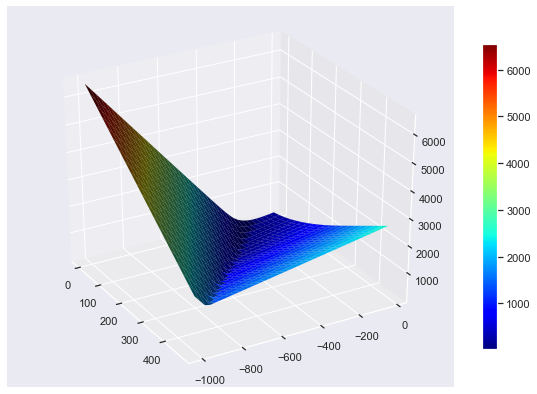

In [8]:
# And plot the surface to visualise the problem

plotter(find_margin_loss_analytic)

In [9]:
# And a numeric equivalent of the above solution, using Newton to find roots around the circle numerically

def find_worst_direction_and_margin_loss(g, B, c=0.15):

    # If positive semidefinite, and global solution inside circle, return this point
    eigenvalues, eigenvectors = np.linalg.eig(B)
    if np.all(eigenvalues > 0.):
        maximiser = -np.linalg.inv(B).dot(g)
        distance = maximiser.dot(maximiser.transpose())[0, 0]

        if distance < c**2:
            root = np.ravel(maximiser)
            return val_func(root, g, B), root

    # Otherwise, do Newton optimisation around theta, starting from several points (hopefully this find all minima...)
    f = lambda y: min_theta_grad(y, g, B)

    roots = []
    for x in np.linspace(0, 6.2, 10):
        try:
            root = newton(f, x, tol=1e-4).round(5)
            roots.append(root)
        except RuntimeError:
            continue

    roots = set(roots)
    roots = [(x, min_theta(x, g, B)) for x in roots if x < 2*np.pi - 1e-6 and x > 0]

    worst_angle, margin = sorted(roots, key = lambda x: x[1])[0]
    worst_direction = np.array([c*np.cos(worst_angle), c*np.sin(worst_angle)])

    return margin, worst_direction


def find_margin_loss_newton(n_ij, c=0.15):
    g, B = calculate_matrices(n_ij)
    margin, direction = find_worst_direction_and_margin_loss(g, B, c)

    return margin

In [10]:
results = outer_optimise(find_margin_loss_newton)

print("Gross volume traded: {}".format(results.fun))
print("Net positions traded: {}".format(results.x))

print("Final positions: {}".format(positions - np.sign(positions) * results.x))

Gross volume traded: 685.6844827170415
Net positions traded: [2.52088653e+02 4.33595830e+02 9.78929588e-09]
Final positions: [ 247.91134685 -566.40417044  499.99999999]


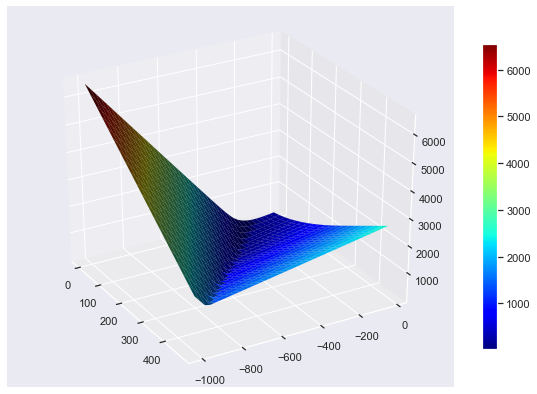

In [11]:
# And plot this surface too

plotter(find_margin_loss_newton)